# Explore netcdf-4 imagery of LS-8 NBAR

- wofs/notebooks/LS8_nbart_composite_nctile_for_water_classif.ipynb

## See also:
- wofs/Zlocaltest/my10_agdcv2_wofs_extents.ipynb
- wofs/notebooks/netcdf4_pixeldrills.ipynb

In [1]:
RDIR='/Softdata/datasets_links/LS8_nbart'
RDIR= '/g/data/u46/fxz547/datasets_links/LS8_nbart' #'/g/data/u46/bb/output/clean_pixel3'

# ALbers cell 15_-40 over Canberra
bands_ncfiles=(
#     'LANDSAT_8_nbart_015_-41_20130101_20131231_JUN01_AUG31_BLUE_MEDIAN.nc'
#     ,'LANDSAT_8_nbart_015_-41_20130101_20131231_JUN01_AUG31_GREEN_MEDIAN.nc'
#     ,'LANDSAT_8_nbart_015_-41_20130101_20131231_JUN01_AUG31_RED_MEDIAN.nc' 
#     ,'LANDSAT_8_nbart_015_-41_20130101_20131231_JUN01_AUG31_NEAR_INFRARED_MEDIAN.nc'
#     ,'LANDSAT_8_nbart_015_-41_20130101_20131231_JUN01_AUG31_SHORT_WAVE_INFRARED_1_MEDIAN.nc'
#     ,'LANDSAT_8_nbart_015_-41_20130101_20131231_JUN01_AUG31_SHORT_WAVE_INFRARED_2_MEDIAN.nc'
    'LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_BLUE_MEDIAN.nc'
    ,'LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_GREEN_MEDIAN.nc'
    ,'LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_RED_MEDIAN.nc'
    ,'LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_NEAR_INFRARED_MEDIAN.nc'
    ,'LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_SHORT_WAVE_INFRARED_1_MEDIAN.nc'
    ,'LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_SHORT_WAVE_INFRARED_2_MEDIAN.nc'
    )


In [2]:
import os
import re
import sys
import numpy as np
import netCDF4
import rasterio
from glob import glob
from datetime import datetime
from collections import namedtuple
from osgeo import osr

%matplotlib inline
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False  # disable scalar formatter / offset in axes labels

In [3]:
path2bands = [os.path.join(RDIR,ncfile) for ncfile in bands_ncfiles ]

print path2bands


['/g/data/u46/fxz547/datasets_links/LS8_nbart/LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_BLUE_MEDIAN.nc', '/g/data/u46/fxz547/datasets_links/LS8_nbart/LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_GREEN_MEDIAN.nc', '/g/data/u46/fxz547/datasets_links/LS8_nbart/LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_RED_MEDIAN.nc', '/g/data/u46/fxz547/datasets_links/LS8_nbart/LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_NEAR_INFRARED_MEDIAN.nc', '/g/data/u46/fxz547/datasets_links/LS8_nbart/LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_SHORT_WAVE_INFRARED_1_MEDIAN.nc', '/g/data/u46/fxz547/datasets_links/LS8_nbart/LANDSAT_8_nbart_015_-40_20130101_20131231_JUN01_AUG31_SHORT_WAVE_INFRARED_2_MEDIAN.nc']


In [30]:
datasets = [netCDF4.Dataset(path2f) for path2f in path2bands]

# print ds_blue.data_model
# print ds_blue.variables

data1= datasets[1]['median_stats'] 
print data1.size, data1.dtype, data1.shape

# %timeit read1(data1)

16000000 int16 (4000, 4000)


In [32]:
print (datasets[3]['median_2013'][1047, 1361], datasets[2]['median_stats'][1047, 1361])

(261, -261)


579


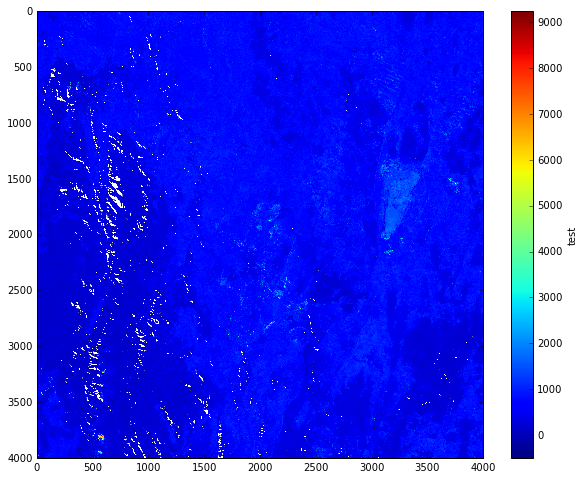

In [33]:
print data1[1,1]

plt.imshow(datasets[1]['median_stats'][:,:])
plt.colorbar(orientation='vertical', shrink=0.8, label='test')

In [7]:
# define a scale function to strech image
def scale_array(arr, prcnt, min_val, max_val, nan_val):
    # Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val' and 'max_val', 
    # replacing 'nan_val' values with NaN's.
    f_arr = 1.0*arr #.astype('float')    # required for NaN's 
    f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    return f_arr

In [8]:
import numpy as np
sB1data = scale_array(datasets[2]['median_stats'][:,:], 99.0, 0, 255, -999)
sB2data = scale_array(datasets[1]['median_stats'][:,:], 99.0, 0, 255, -999)
sB3data = scale_array(datasets[0]['median_stats'][:,:], 99.0, 0, 255, -999)
# sB4data = scale_array(B4data, 99.0, 0, 255, -999)
# sB5data = scale_array(B5data, 99.0, 0, 255, -999)
# sB7data = scale_array(B7data, 99.0, 0, 255, -999)
y_size = data1.shape[0]; x_size = data1.shape[1]
FC_image = np.zeros((y_size, x_size, 3), dtype='uint8')
FC_image[:,:,0] = sB1data; FC_image[:,:,1] = sB2data; FC_image[:,:,2] = sB3data

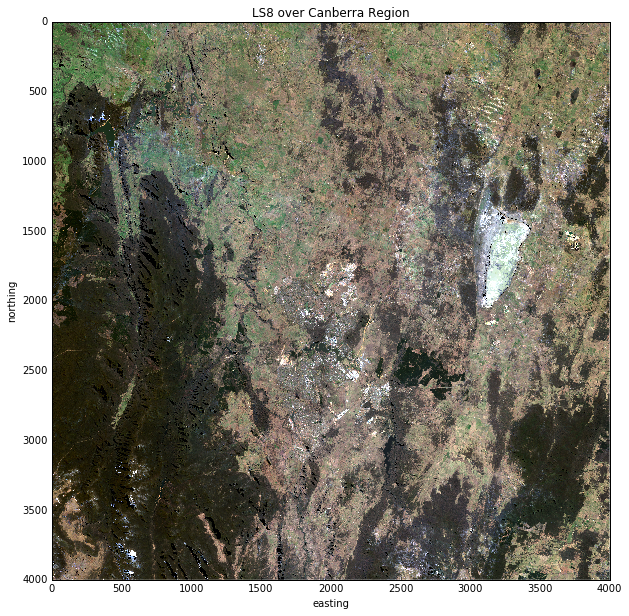

In [9]:
plt.imshow(FC_image, interpolation='none') #, extent=[L5xvec[0],L5xvec[-1],L5yvec[-1],L5yvec[0]], aspect=1)
plt.title('LS8 over Canberra Region')
plt.ylabel('northing'); plt.xlabel('easting');

In [10]:
import numpy
import gc
def classify(images, float64=False):
    """
Produce a water classification image from the supplied images (6 bands of an NBAR, multiband Landsat image)
This method evaluates N.Mueller's decision tree as follows:


                    -----------------------------N1---------------------------------
                    |                                                              |
                    |                                                              |
                 ---N2-----                                           -------------N21---------------------
                 |        |                                           |                                   |
                 |        |                                           |                                   |
       ----------N4----   N3                                    ------N22---                           ---N35-------
       |              |                                         |          |                           |           |
       |              |                                         |          |                           |           |
    ---N5---       ---N8--------------                       ---N24----    N23                      ---N37------   N36
    |      |       |                 |                       |        |                             |          |
    |      |       |                 |                       |        |                             |          |
    N6     N7   ---N12------------   N9             ---------N26---   N25                        ---N39-----   N38
                |                |                  |             |                              |         |
                |                |                  |             |                              |         |
             ---N16---        ---N13---             N27   --------N28---                   ------N41---    N40
             |       |        |       |                   |            |                   |          |
             |       |        |       |                   |            |                   |          |
             N17  ---N18---   N14     N15              ---N29---    ---N30---           ---N43---     N42
                  |       |                            |       |    |       |           |       |
                  |       |                            |       |    |       |           |       |
                  N19     N20                          N31     N32  N33     N34         N44     N45


:param images:
    A 3D numpy array ordered in (bands,rows,columns), containing the spectral data.
    It is assumed that the spectral bands follow Landsat 5 & 7, Band 1, Band 2, Band 3, Band 4, Band 5, Band 7.

:param float64:
    Boolean keyword. If set to True then the data will be converted to type float64 if not already float64.
    Default is False.

:return:
    A 2D numpy array of type UInt8.  Values will be 0 for No Water, 1 for Unclassified and 128 for water.

:notes:
    The input array will be converted to type float32 if not already float32.
    If images is of type float64, then images datatype will be left as is.

:transcription:
    Transcribed from a Tree diagram output by CART www.salford-systems.com
    Josh Sixsmith; joshua.sixsmith@ga.gov.au

    """

#     logger = logging.getLogger("WaterClasserfier")
#     logger.debug("Started")

    def band_ratio(a,b):
        """
        Calculates a normalised ratio index.
        """
        c = (a - b) / (a + b)
        return c

    dims = images.shape
    if len(dims) == 3:
        bands = dims[0]
        rows  = dims[1]
        cols  = dims[2]
    else:
        rows = dims[0]
        cols = dims[1]

    dtype = images.dtype

    # Check whether to enforce float64 calcs, unless the datatype is already float64
    # Otherwise force float32
    if float64:
        if (dtype != 'float64'):
            images = images.astype('float64')
    else:
        if (dtype == 'float64'):
            # Do nothing, leave as float64
            images = images
        elif (dtype != 'float32'):
            images = images.astype('float32')

    classified = numpy.ones((rows,cols), dtype='uint8')

    NDI_52 = band_ratio(images[4], images[1])
    NDI_43 = band_ratio(images[3], images[2])
    NDI_72 = band_ratio(images[5], images[1])

    b1 = images[0]
    b2 = images[1]
    b3 = images[2]
    b4 = images[3]
    b5 = images[4]
    b7 = images[5]

    # Lets start going down the trees left branch, finishing nodes as needed
    # Lots of result arrays eg r1, r2 etc of type bool are created
    # These could be recycled to save memory, but at the moment they serve to show the tree structure
    # Temporary arrays of type bool (_tmp, _tmp2) are used to combine the boolean decisions
    r1 = NDI_52 <= -0.01

    r2 = b1 <= 2083.5
    classified[r1 & ~r2] = 0 # Node 3

    r3 = b7 <= 323.5
    _tmp = r1 & r2
    _tmp2 = _tmp & r3
    _tmp &= ~r3

    r4 = NDI_43 <= 0.61
    classified[_tmp2 & r4]  = 128 # Node 6
    classified[_tmp2 & ~r4] = 0 # Node 7

    r5 = b1 <= 1400.5
    _tmp2 = _tmp & ~r5
    r6 = NDI_43 <= -0.01
    classified[_tmp2 & r6]  = 128 # Node 10
    classified[_tmp2 & ~r6] = 0 # Node 11

    _tmp &= r5

    r7 = NDI_72 <= -0.23
    _tmp2 = _tmp & ~r7
    r8 = b1 <= 379
    classified[_tmp2 & r8]  = 128 # Node 14
    classified[_tmp2 & ~r8] = 0 # Node 15

    _tmp &= r7

    r9 = NDI_43 <= 0.22
    classified[_tmp & r9] = 128 # Node 17

    _tmp &= ~r9

    r10 = b1 <= 473
    classified[_tmp & r10]  = 128 # Node 19
    classified[_tmp & ~r10] = 0 # Node 20

    # Left branch is completed; cleanup
    #logger.debug("B4 cleanup 1")
    del r2, r3, r4, r5, r6, r7, r8, r9, r10
    gc.collect()
    #logger.debug("cleanup 1 done")

    # Right branch of the tree
    r1 = ~r1

    r11 = NDI_52 <= 0.23
    _tmp = r1 & r11

    r12 = b1 <= 334.5
    _tmp2 = _tmp & ~r12
    classified[_tmp2] = 0 # Node 23

    _tmp &= r12

    r13 = NDI_43 <= 0.54
    _tmp2 = _tmp & ~r13
    classified[_tmp2] = 0 # Node 25

    _tmp &= r13

    r14 = NDI_52 <= 0.12
    _tmp2 = _tmp & r14
    classified[_tmp2] = 128 # Node 27

    _tmp &= ~r14

    r15 = b3 <= 364.5
    _tmp2 = _tmp & r15

    r16 = b1 <= 129.5
    classified[_tmp2 & r16]  = 128 # Node 31
    classified[_tmp2 & ~r16] = 0 # Node 32

    _tmp &= ~r15

    r17 = b1 <= 300.5
    _tmp2 = _tmp & ~r17
    _tmp &= r17
    classified[_tmp]  = 128 # Node 33
    classified[_tmp2] = 0 # Node 34

    _tmp = r1 & ~r11

    r18 = NDI_52 <= 0.34
    classified[_tmp & ~r18] = 0 # Node 36
    _tmp &= r18

    r19 = b1 <= 249.5
    classified[_tmp & ~r19] = 0 # Node 38
    _tmp &= r19

    r20 = NDI_43 <= 0.45
    classified[_tmp & ~r20] = 0 # Node 40
    _tmp &= r20

    r21 = b3 <= 364.5
    classified[_tmp & ~r21] = 0 # Node 42
    _tmp &= r21

    r22 = b1 <= 129.5
    classified[_tmp & r22]  = 128 # Node 44
    classified[_tmp & ~r22] = 0 # Node 45

    #logger.debug("completed")

    return classified


In [11]:
y_size=4000
x_size=4000
raw_image = np.zeros((6, y_size, x_size), dtype='float32')

In [12]:
for i in range(0,6):
    print i
    if (i <=2): 
        raw_image[i,:,:] = datasets[i]['median_stats'][:,:]
    if (i>2):
        raw_image[i,:,:] = datasets[i]['median_2013'][:,:]

0
1
2
3
4
5


In [13]:
clfimg= classify(raw_image)

/g/data1/u46/users/fxz547/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in divide
/g/data1/u46/users/fxz547/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in divide
/g/data1/u46/users/fxz547/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:104: RuntimeWarning: invalid value encountered in less_equal
/g/data1/u46/users/fxz547/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:114: RuntimeWarning: invalid value encountered in less_equal
/g/data1/u46/users/fxz547/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:120: RuntimeWarning: invalid value encountered in less_equal
/g/data1/u46/users/fxz547/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:126: RuntimeWarning: invalid value encountered in less_equal
/g/data1/u46/users/fxz547/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: invalid value encoun

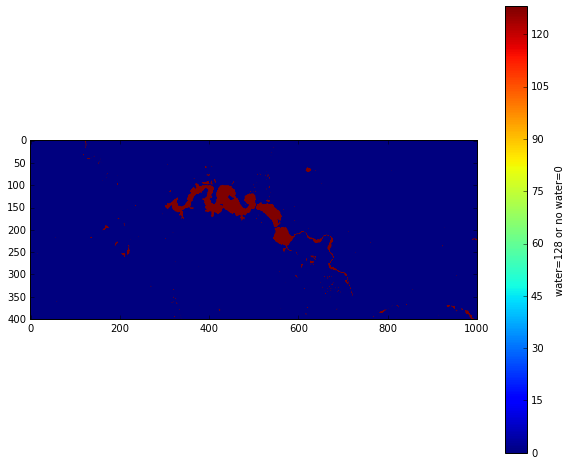

In [14]:
# display all or part of the classified image
plt.imshow(clfimg[2200:2600,1500:2500])
plt.colorbar(orientation='vertical', shrink=0.8, label='water=128 or no water=0');

In [15]:
# calculate the NDWater Indexes
# how to cluster the image?
# how to extract water pixels features? characteristics
print clfimg[2250,1525]

0


In [21]:
NDWI_GAO = (1.0*(datasets[3]['median_2013'][:,:]- datasets[2]['median_stats'][:,:])+0.01)/(0.01+datasets[3]['median_2013'][:,:] + datasets[2]['median_stats'][:,:])

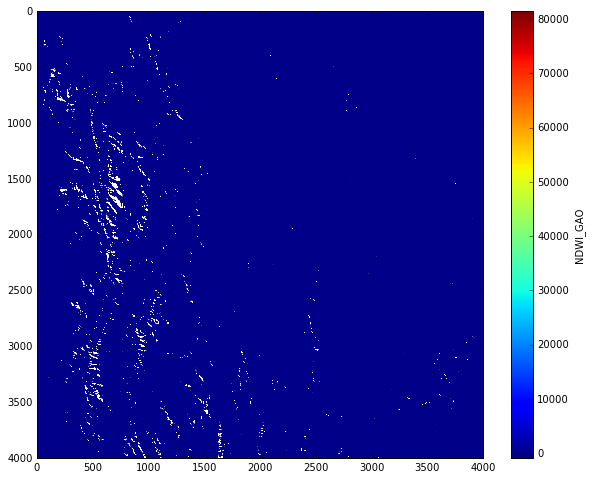

In [22]:
plt.imshow(NDWI_GAO)  #datasets[4]['median_2013'])
plt.colorbar(orientation='vertical', shrink=0.8, label='NDWI_GAO');

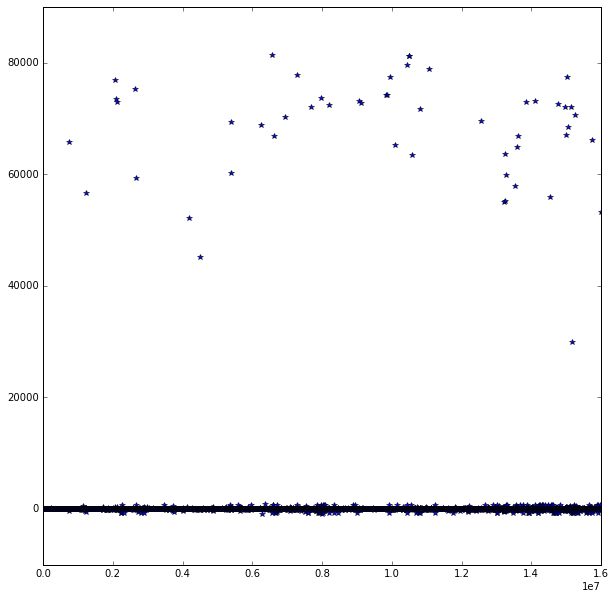

In [24]:
plt.plot(NDWI_GAO.flatten(), "*")

In [31]:
print (datasets[3]['median_2013'][1047, 1361], datasets[2]['median_stats'][1047, 1361])

(261, -261)


In [26]:
for index, v in np.ndenumerate(NDWI_GAO):
    if v > 1000.0:
        print index, v

(183, 1097) 65801.0000001
(310, 208) 56601.0000001
(516, 144) 76801.0000001
(524, 152) 73401.0000001
(528, 229) 73001.0000001
(657, 635) 75201.0000001
(667, 755) 59401.0000001
(1047, 1361) 52201.0
(1125, 293) 45201.0
(1345, 825) 69401.0000001
(1349, 564) 60201.0000001
(1565, 566) 68801.0000001
(1644, 303) 81401.0000001
(1657, 675) 66801.0000001
(1736, 988) 70201.0000001
(1819, 650) 77801.0000001
(1921, 714) 72001.0000001
(1989, 705) 73601.0000001
(2049, 814) 72401.0000001
(2261, 978) 73201.0000001
(2281, 813) 72801.0000001
(2461, 488) 74201.0000001
(2462, 488) 74201.0000001
(2484, 502) 77401.0000001
(2520, 1089) 65201.0000001
(2611, 933) 79601.0000001
(2622, 354) 81201.0000001
(2622, 355) 81201.0000001
(2646, 1045) 63401.0000001
(2699, 668) 71601.0000001
(2763, 320) 78801.0000001
(3136, 534) 69601.0000001
(3305, 1874) 55001.0000001
(3308, 2471) 63601.0000001
(3312, 2505) 55201.0000001
(3315, 1882) 59801.0000001
(3384, 1788) 57801.0000001
(3400, 2501) 64801.0000001
(3403, 842) 66801.000